In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc

from sklearn.utils import resample

import warnings
pd.set_option('display.max_colwidth', -1)
df = pd.read_csv('semua_terpakai.csv', encoding = 'utf-16')
df['POS']= np.where(df['senti'] == 'positif', '1', '0')
df['NET']= np.where(df['senti'] == 'netral', '1', '0')
df['NEG']= np.where(df['senti'] == 'negatif', '1', '0')
df['TER']= np.where(df['level_bahasa'] == 'teratur', '1', '0')
df['SED']= np.where(df['level_bahasa'] == 'sedang', '1', '0')
df['TTE']= np.where(df['level_bahasa'] == 'tidak teratur', '1', '0')
df['IND']= np.where(df['jenis_bahasa'] == 'Indonesia_murni', '1', '0')
df['CBI']= np.where(df['jenis_bahasa'] == 'campur_bahasa_Inggris', '1', '0')
df['CBD']= np.where(df['jenis_bahasa'] == 'campur_bahasa_daerah', '1', '0')
df['ENG']= np.where(df['jenis_bahasa'] == 'Inggris_murni', '1', '0')

df.senti.value_counts()

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


netral     588
negatif    560
positif    274
Name: senti, dtype: int64

In [2]:
import pandas as pd
import nltk

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
otw_stem= df['Comment'].tolist()
content_final = []
#print(otw_stem)
token_dict = {}
content_stemmed = map(lambda x: stemmer.stem(x), otw_stem)
#print(content_stemmed)

for news in content_stemmed: 
	word_token = nltk.word_tokenize(news) # get word token for every news (split news into each separate words)
	word_token = [word for word in word_token if not word in nltk.corpus.stopwords.words('indonesian') and not word[0].isdigit()] # remove indonesian stop words and number
	content_final.append(" ".join(word_token))
    
print(content_final)
from nltk.corpus import stopwords
stop = stopwords.words('indonesian')

df['tersastrawi']=content_final
#df.to_csv('coba_lstm_tersastrawi.csv', mode='w', index=False, encoding="utf-16")
df['tersastrawi_nostop']=df['tersastrawi'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#df['tersastrawi_nostop_tokenize']=df['tersastrawi_nostop'].apply(nltk.word_tokenize)
df

['seni bahasa perintah new normal protokol sehat psbb', 'we need thanos to bring balance to the our universe', 'serah ngomong pusing denger ngomong', 'protokol parkir motor helm hilang resiko tanggung', 'ga bayang hidup jam yg serba salah ga bayang mayat jalan ricuh huru hara mdh mdhan tdk', 'moga dlm lindung allah subhanahu wataala aamiin', 'menang d adil dunia tunggu adil akhirat', 'new normal kalah cepet cm ngejiplak istilah rangga expired', 'stay home rumah aja sosial distancing psbb new world order new normal miripin aja ya negara american -', 'benwr sunda empire klo ga tunduk sma tatanan dunia hancur wkwkwwk', 'moga selamat dunia aherat lawan covid jaga bersih jaga sehat', 'alhamdulillah smga negri bangkit indonesia ku', 'mudah han new normal masyarakat yg ekonomi lemah bangkit amin amin amin', 'bismillah ya allah moga engkau hilang virus dunia musnah ya allah', 'doa smua rakyat indonesia dunia doa smoga wabah covid aminn', 'hidup indonesia mah simpel nggak mati kena corona ya ma

,Comment,sentiment,senti,jenis_bahasa,level_bahasa,POS,NET,NEG,TER,SED,TTE,IND,CBI,CBD,ENG,tersastrawi,tersastrawi_nostop
0,seni bahasa pemerintah new normal protokol kesehatan psbb,-0.143181818,negatif,campur_bahasa_Inggris,sedang,0,0,1,0,1,0,0,1,0,0,seni bahasa perintah new normal protokol sehat psbb,seni bahasa perintah new normal protokol sehat psbb
1,we need thanos to bring balance to the our universe,0,netral,Inggris_murni,teratur,0,1,0,1,0,0,0,0,0,1,we need thanos to bring balance to the our universe,we need thanos to bring balance to the our universe
2,terserah lah mau ngomong apa pusing denger dia ngomong,-0.1,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0,serah ngomong pusing denger ngomong,serah ngomong pusing denger ngomong
3,mirip protokol di parkiran motor helm hilang resiko di tanggung sendiri,-0.6,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0,protokol parkir motor helm hilang resiko tanggung,protokol parkir motor helm hilang resiko tanggung
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0,ga bayang hidup jam yg serba salah ga bayang mayat jalan ricuh huru hara mdh mdhan tdk,ga bayang hidup jam yg serba salah ga bayang mayat jalan ricuh huru hara mdh mdhan tdk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,new normal bukan hanya ditempat rame tapi terpenting new normal di mesjid,0.187272727,positif,Indonesia_murni,teratur,1,0,0,1,0,0,1,0,0,0,new normal rame new normal mesjid,new normal rame new normal mesjid
1421,arab saudi akan kembali normal mulai tgl juni semua activitas kembali seperti biasa kecualinkota mekkah dn penerbangan internasional masih ditangguhkan,0.15,positif,Indonesia_murni,sedang,1,0,0,0,1,0,1,0,0,0,arab saudi normal tgl juni activitas kecualinkota mek dn terbang internasional tangguh,arab saudi normal tgl juni activitas kecualinkota mek dn terbang internasional tangguh
1422,bismillah semoga selalu diberikn ksehtan tuk kita semua tetap jg jarak,0.1,positif,Indonesia_murni,teratur,1,0,0,1,0,0,1,0,0,0,bismillah moga diberikn ksehtan tuk jg jarak,bismillah moga diberikn ksehtan tuk jg jarak
1423,bpk ridwan kamil idolaku kelak jd capres amin sangat jelas cara penyampaian nya mantap,0.148333333,positif,Indonesia_murni,teratur,1,0,0,1,0,0,1,0,0,0,bpk ridwan kamil idola kelak jd capres amin nya mantap,bpk ridwan kamil idola kelak jd capres amin nya mantap


In [3]:
df.tersastrawi=df.tersastrawi.astype(str)
df

,Comment,sentiment,senti,jenis_bahasa,level_bahasa,POS,NET,NEG,TER,SED,TTE,IND,CBI,CBD,ENG,tersastrawi,tersastrawi_nostop
0,seni bahasa pemerintah new normal protokol kesehatan psbb,-0.143181818,negatif,campur_bahasa_Inggris,sedang,0,0,1,0,1,0,0,1,0,0,seni bahasa perintah new normal protokol sehat psbb,seni bahasa perintah new normal protokol sehat psbb
1,we need thanos to bring balance to the our universe,0,netral,Inggris_murni,teratur,0,1,0,1,0,0,0,0,0,1,we need thanos to bring balance to the our universe,we need thanos to bring balance to the our universe
2,terserah lah mau ngomong apa pusing denger dia ngomong,-0.1,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0,serah ngomong pusing denger ngomong,serah ngomong pusing denger ngomong
3,mirip protokol di parkiran motor helm hilang resiko di tanggung sendiri,-0.6,negatif,Indonesia_murni,sedang,0,0,1,0,1,0,1,0,0,0,protokol parkir motor helm hilang resiko tanggung,protokol parkir motor helm hilang resiko tanggung
4,ga kebayang kita hidup dijaman yg serba salah ga kebayang suatu saat banyak mayat dijalan ricuh huru hara mdh mdhan tdk terjadi,0,netral,Indonesia_murni,sedang,0,1,0,0,1,0,1,0,0,0,ga bayang hidup jam yg serba salah ga bayang mayat jalan ricuh huru hara mdh mdhan tdk,ga bayang hidup jam yg serba salah ga bayang mayat jalan ricuh huru hara mdh mdhan tdk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,new normal bukan hanya ditempat rame tapi terpenting new normal di mesjid,0.187272727,positif,Indonesia_murni,teratur,1,0,0,1,0,0,1,0,0,0,new normal rame new normal mesjid,new normal rame new normal mesjid
1421,arab saudi akan kembali normal mulai tgl juni semua activitas kembali seperti biasa kecualinkota mekkah dn penerbangan internasional masih ditangguhkan,0.15,positif,Indonesia_murni,sedang,1,0,0,0,1,0,1,0,0,0,arab saudi normal tgl juni activitas kecualinkota mek dn terbang internasional tangguh,arab saudi normal tgl juni activitas kecualinkota mek dn terbang internasional tangguh
1422,bismillah semoga selalu diberikn ksehtan tuk kita semua tetap jg jarak,0.1,positif,Indonesia_murni,teratur,1,0,0,1,0,0,1,0,0,0,bismillah moga diberikn ksehtan tuk jg jarak,bismillah moga diberikn ksehtan tuk jg jarak
1423,bpk ridwan kamil idolaku kelak jd capres amin sangat jelas cara penyampaian nya mantap,0.148333333,positif,Indonesia_murni,teratur,1,0,0,1,0,0,1,0,0,0,bpk ridwan kamil idola kelak jd capres amin nya mantap,bpk ridwan kamil idola kelak jd capres amin nya mantap


In [4]:
df_=df.drop(['Comment','sentiment','senti','jenis_bahasa','level_bahasa','TER','SED','TTE','IND','CBI','CBD','ENG','tersastrawi_nostop'], axis =1)
df_

,POS,NET,NEG,tersastrawi
0,0,0,1,seni bahasa perintah new normal protokol sehat psbb
1,0,1,0,we need thanos to bring balance to the our universe
2,0,0,1,serah ngomong pusing denger ngomong
3,0,0,1,protokol parkir motor helm hilang resiko tanggung
4,0,1,0,ga bayang hidup jam yg serba salah ga bayang mayat jalan ricuh huru hara mdh mdhan tdk
...,...,...,...,...
1420,1,0,0,new normal rame new normal mesjid
1421,1,0,0,arab saudi normal tgl juni activitas kecualinkota mek dn terbang internasional tangguh
1422,1,0,0,bismillah moga diberikn ksehtan tuk jg jarak
1423,1,0,0,bpk ridwan kamil idola kelak jd capres amin nya mantap


In [5]:
df_['POS']=df_['POS'].astype(int)
df_['NET']=df_['NET'].astype(int)
df_['NEG']=df_['NEG'].astype(int)

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_, test_size=0.2, random_state = 23)
train

,POS,NET,NEG,tersastrawi
1332,0,0,1,new mormal covid ya
739,0,1,0,tettttttttt
480,0,1,0,stop wna yg masuk dr jaga rakyat keluarga jaga sehat hidup
226,0,0,1,new normal ya yg korban masyarakat perintah duduk manis dr ramai
22,0,0,1,ridwan kamil mesra banget summarecon bandung yg ngasih ijin bangun summarecon gedebage pdhl zona hijau resap
...,...,...,...,...
31,0,1,0,new presiden
950,0,1,0,selamat ekonomi rakyat selamat ekonomi bisnis ritel taipan pakdhe
1064,0,1,0,yuk kawan kawan masjid buka biar sholat jamaah aceh buka trs sampe skrg aman aman aja
742,1,0,0,tuju de


In [7]:
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["tersastrawi"]
list_sentences_test = test["tersastrawi"]

In [8]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
list_tokenized_train[:1]

[[2, 1131, 10, 6]]

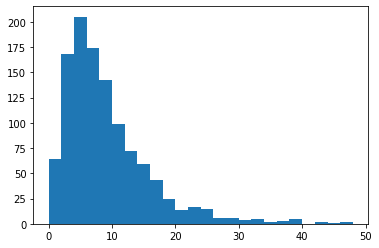

In [9]:
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,50,2))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [10]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [11]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [12]:


#Loading pre-trained embeddings
print("loading word2vec...")
# start = time.time()
word_vectors = KeyedVectors.load_word2vec_format("model300.bin",
                                                 binary="True", unicode_errors='ignore')
# end = time.time()
# print("word2vec loading done in {} seconds".format(end-start))

word2vec = word_vectors
embed_dim = 300

loading word2vec...


In [13]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

2161 766
known words: 2161
unknown words: 766


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [14]:
print(emb_init_values)

[[-0.11076635 -0.05123871 -0.36495847 ... -0.7535308  -0.3139119
  -1.0396185 ]
 [ 1.9398055   0.9223579   1.1527607  ... -0.35870504 -3.8962324
  -0.5033255 ]
 [ 1.4031776   0.5934335   0.40442282 ... -0.35535118  0.5263745
  -0.6059853 ]
 ...
 [ 0.14511752 -0.20396541 -0.21716958 ... -0.1799374  -0.2300708
   0.02609892]
 [ 0.04632214 -0.03669264 -0.07316303 ... -0.12245896  0.13182487
  -0.24845278]
 [ 0.0555751   0.24089818  0.07336731 ...  0.18993074 -0.10294811
  -0.08568907]]


In [15]:
emb_init_values.shape

(2928, 300)

In [16]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [17]:
inp = Input(shape=(maxlen,))

In [18]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   POS          1425 non-null   int32 
 1   NET          1425 non-null   int32 
 2   NEG          1425 non-null   int32 
 3   tersastrawi  1425 non-null   object
dtypes: int32(3), object(1)
memory usage: 28.0+ KB


In [19]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
#x = GRU(200, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

Epoch 1/100

 ROC-AUC - epoch: 1 - score: 0.654842 

36/36 - 9s - loss: 0.6273 - accuracy: 0.4640 - val_loss: 0.5850 - val_accuracy: 0.5228
Epoch 2/100

 ROC-AUC - epoch: 2 - score: 0.669793 

36/36 - 8s - loss: 0.6147 - accuracy: 0.4737 - val_loss: 0.5732 - val_accuracy: 0.5263
Epoch 3/100

 ROC-AUC - epoch: 3 - score: 0.656287 

36/36 - 8s - loss: 0.5936 - accuracy: 0.5053 - val_loss: 0.5792 - val_accuracy: 0.5509
Epoch 4/100

 ROC-AUC - epoch: 4 - score: 0.691086 

36/36 - 8s - loss: 0.5725 - accuracy: 0.5316 - val_loss: 0.5630 - val_accuracy: 0.5263
Epoch 5/100

 ROC-AUC - epoch: 5 - score: 0.697808 

36/36 - 8s - loss: 0.5397 - accuracy: 0.5632 - val_loss: 0.5747 - val_accuracy: 0.5158
Epoch 6/100

 ROC-AUC - epoch: 6 - score: 0.692194 

36/36 - 8s - loss: 0.4912 - accuracy: 0.6482 - val_loss: 0.5886 - val_accuracy: 0.5263
Epoch 7/100

 ROC-AUC - epoch: 7 - score: 0.668945 

36/36 - 7s - loss: 0.4005 - accuracy: 0.7325 - val_loss: 0.6639 - val_accuracy: 0.5333
Epoch 8/100

 ROC-AU

In [20]:
X_te.shape

(285, 50)

In [21]:
X_t.shape

(1140, 50)

In [22]:
from keras.models import load_model
c = model.predict(X_te)
c

array([[9.67885426e-05, 2.54292935e-01, 7.95274854e-01],
       [6.46918237e-01, 1.07663870e-02, 2.08017617e-01],
       [4.57539073e-09, 9.93965983e-01, 3.33479047e-03],
       [8.89537752e-01, 6.08263016e-02, 6.67082965e-02],
       [7.72565603e-04, 5.63433766e-03, 9.75926161e-01],
       [6.00644946e-03, 9.34525073e-01, 2.37765014e-02],
       [3.05998174e-06, 9.99986708e-01, 3.81407830e-08],
       [1.11929355e-11, 9.99194205e-01, 4.59909439e-04],
       [7.69994557e-09, 9.99999404e-01, 3.11956363e-08],
       [1.06340553e-06, 9.99831080e-01, 5.25645846e-05],
       [9.99997973e-01, 1.62762710e-08, 5.21193222e-09],
       [2.33723819e-02, 9.31075394e-01, 2.71265209e-02],
       [9.92111027e-01, 1.84018016e-02, 2.36030919e-05],
       [1.95037944e-19, 1.71542153e-20, 1.00000000e+00],
       [8.56130531e-12, 9.99998569e-01, 2.68773334e-07],
       [1.19546556e-07, 7.02868741e-09, 9.99999046e-01],
       [3.63586878e-07, 3.86452712e-07, 9.99986589e-01],
       [3.21520711e-05, 1.17019

In [23]:
test

,POS,NET,NEG,tersastrawi
663,0,0,1,bijak blunder
122,0,1,0,hahaha
2,0,0,1,serah ngomong pusing denger ngomong
1063,0,1,0,yg d omongin disiplin masyarakat tp tingi pda d siplin
253,0,0,1,sdh bilang data kadang lambat akurat bisnis mulu sih
...,...,...,...,...
776,0,0,1,hukum perda laksana new normal jalan bunuh
791,0,0,1,ekonomi selamat rakyat sekarat
1050,0,0,1,hahhh new order
1354,1,0,0,sdh percaya dg perintah coba dg new normal agr normal taat protokol dg masker cuci tangan ibadah mhn ampun pd alloh swt


In [24]:
df_.describe()

,POS,NET,NEG
count,1425.000000,1425.000000,1425.000000
mean,0.192281,0.412632,0.392982
std,0.394231,0.492480,0.488584
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [25]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 77ms/step - loss: 2.5937 - accuracy: 0.4877
Test accuracy: 0.4877192974090576


In [26]:
print(model.metrics_names)

['loss', 'accuracy']


In [27]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.6361602391131829

In [28]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

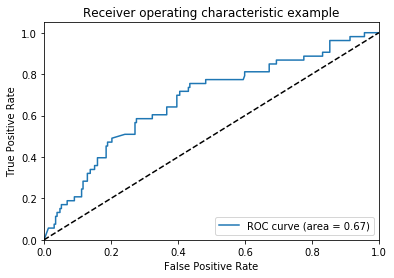

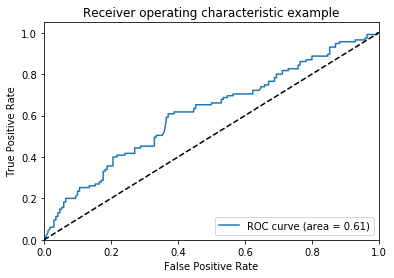

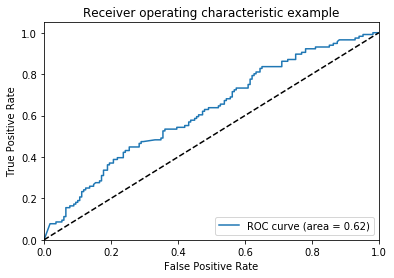

In [29]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
y_pred

array([[9.67885426e-05, 2.54292935e-01, 7.95274854e-01],
       [6.46918237e-01, 1.07663870e-02, 2.08017617e-01],
       [4.57539073e-09, 9.93965983e-01, 3.33479047e-03],
       [8.89537752e-01, 6.08263016e-02, 6.67082965e-02],
       [7.72565603e-04, 5.63433766e-03, 9.75926161e-01],
       [6.00644946e-03, 9.34525073e-01, 2.37765014e-02],
       [3.05998174e-06, 9.99986708e-01, 3.81407830e-08],
       [1.11929355e-11, 9.99194205e-01, 4.59909439e-04],
       [7.69994557e-09, 9.99999404e-01, 3.11956363e-08],
       [1.06340553e-06, 9.99831080e-01, 5.25645846e-05],
       [9.99997973e-01, 1.62762710e-08, 5.21193222e-09],
       [2.33723819e-02, 9.31075394e-01, 2.71265209e-02],
       [9.92111027e-01, 1.84018016e-02, 2.36030919e-05],
       [1.95037944e-19, 1.71542153e-20, 1.00000000e+00],
       [8.56130531e-12, 9.99998569e-01, 2.68773334e-07],
       [1.19546556e-07, 7.02868741e-09, 9.99999046e-01],
       [3.63586878e-07, 3.86452712e-07, 9.99986589e-01],
       [3.21520711e-05, 1.17019

In [31]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
y_pred

array([[0., 1., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 1., 0.],
       [1., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 1., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0

In [32]:
y_te

array([[0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [1,

In [33]:
roc_auc_score(y_te, y_pred)

0.6065061766872509

In [34]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[174  58]
  [ 26  27]]

 [[102  68]
  [ 44  71]]

 [[109  60]
  [ 56  60]]]
              precision    recall  f1-score   support

           0       0.32      0.51      0.39        53
           1       0.51      0.62      0.56       115
           2       0.50      0.52      0.51       116

   micro avg       0.46      0.56      0.50       284
   macro avg       0.44      0.55      0.49       284
weighted avg       0.47      0.56      0.51       284
 samples avg       0.47      0.55      0.50       284



E:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

In [36]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)


In [37]:
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))

Hamming score: 0.4742690058479532


In [38]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.4105263157894737
Hamming loss: 0.3649122807017544


In [39]:
X_t[:2]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    2, 1131,   10,    6],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 1132]])

In [40]:
X_te.shape

(285, 50)

In [41]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)) 

array([[28, 16, 10],
       [31, 56, 28],
       [26, 42, 48]], dtype=int64)

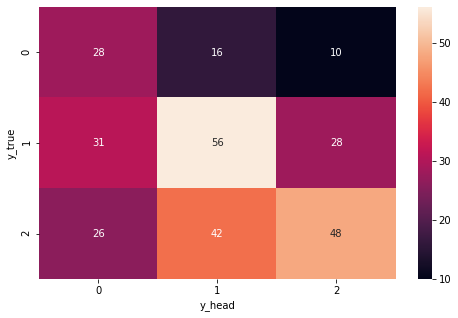

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()